python 3
79: -------------------------------------------------------------------------
This script uses regression analysis to understand the relationhip
between telomere average ratio (as an outcome) and explanatory factors
including age, sex, BMI, and ethnicity.  The analysis is based on
fitting linear models using ordinary least squares, with mean T/S ratio 
(telomere length relative to standard reference DNA)
as the dependent variable, and the explanatory factors as
covariates (independent variables).  All models contain the same
four explanatory variables, but the models are parameterized in
different ways.  Some models are very simple while others have
nonlinear terms and interactions.

The different models are assessed by plotting fitted values for
various subpopulations.  Since all of the regression functions are
well over 3-dimensional, we can plot E[Y|X] against one component of
X, while holding the other components of X equal to reference
values.  For example, we can plot the fitted mean T/S ratio as
a function of age, for each sex, for each ethnic group, and for
people with average BMI.
Updated: Nov 26, 2020
79: -------------------------------------------------------------------------

In [1]:
import numpy as np
import statsmodels.api as sm
from data_prep import get_data
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
dx = get_data(1999)

In [3]:
def plot_fit_by_age(result, fml):

    # Create a dataframe in which all variables are at the reference
    # level
    da = dx.iloc[0:100, :].copy()
    da["RIDAGEYR"] = np.linspace(18, 80, 100)
    da["RIDRETH1"] = "OH"

    plt.figure(figsize=(8, 5))
    plt.clf()
    plt.axes([0.1, 0.1, 0.66, 0.8])
    plt.grid(True)

    for female in 0, 1:
        for bmi in 22, 26, 31:

            db = da.copy()
            db.Female = female
            db.BMXBMI = bmi

            pr = result.predict(exog=db)

            la = "Female" if female == 1 else "Male"
            la += ", BMI=%.0f" % bmi
            plt.plot(da.RIDAGEYR.values, pr.values, '-', label=la)

    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right")
    leg.draw_frame(False)

    plt.xlabel("Age (years)", size=15)
    plt.ylabel("T/S ratio", size=15)
    plt.title(fml, size=11)
    plt.title(fml, fontdict={"fontsize": 9})
    pdf.savefig()

    i0 = result.resid < 0
    i1 = result.resid > 0
    nresid = -result.resid[i0]
    age = result.model.data.frame.RIDAGEYR
    nage = age[i0]
    presid = result.resid[i1]
    page = age[i1]
    x1 = sm.nonparametric.lowess(presid, page, frac=0.5)
    x0 = sm.nonparametric.lowess(nresid, nage, frac=0.5)
    plt.clf()
    plt.axes([0.1, 0.1, 0.73, 0.8])
    plt.grid(True)
    plt.plot(x0[:, 0], x0[:, 1], '-', label='Negative')
    plt.plot(x1[:, 0], x1[:, 1], '-', label='Positive')
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right")
    leg.draw_frame(False)
    plt.xlabel("Age", size=15)
    plt.ylabel("Expected absolute residual", size=15)
    pdf.savefig()

In [4]:
def plot_fit_by_bmi(result, fml):

    # Create a dataframe in which all variables are at the reference
    # level
    da = dx.iloc[0:100, :].copy()
    da["BMXBMI"] = np.linspace(15, 35, 100)
    da["RIDRETH1"] = "OH"

    plt.figure(figsize=(8, 5))
    plt.clf()
    plt.axes([0.1, 0.1, 0.66, 0.8])
    plt.grid(True)

    for female in 0, 1:
        for age in 25, 50, 75:

            db = da.copy()
            db.Female = female
            db.RIDAGEYR = age

            pr = result.predict(exog=db)

            la = "Female" if female == 1 else "Male"
            la += ", age=%.0f" % age
            plt.plot(da.BMXBMI.values, pr.values, '-', label=la)

    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right")
    leg.draw_frame(False)

    plt.xlabel("BMI (kg/m^2)", size=15)
    plt.ylabel("T/S ratio", size=15)
    plt.title(fml, fontdict={"fontsize": 9})
    pdf.savefig()

In [5]:
def plot_basis(xv, xmat, names, degf):

    ii = np.argsort(xv)
    xv = xv[ii]
    xmat = xmat[ii, :]

    plt.clf()
    plt.grid(True)

    for k in range(degf):
        vn = "bs(RIDAGEYR, 5)[%d]" % k
        pos = names.index(vn)
        plt.plot(xv, xmat[:, pos], '-', rasterized=True)

    plt.xlabel("Age (years)", size=15)
    plt.ylabel("Basis function value", size=15)
    plt.title("Spline basis for age (5 df)")
    pdf.savefig()

In [6]:
def plot_fit_by_age_race(result, fml):

    # Create a dataframe in which all variables are at the reference
    # level
    da = dx.iloc[0:100, :].copy()
    da["RIDAGEYR"] = np.linspace(18, 80, 100)
    da["BMXBMI"] = 22

    plt.figure(figsize=(8, 5))
    plt.clf()
    plt.axes([0.1, 0.1, 0.62, 0.8])
    plt.grid(True)

    for female in 0, 1:
        for race in "MA", "NHW", "NHB", "OR", "OH":

            db = da.copy()
            db.Female = female
            db.RIDRETH1 = race

            pr = result.predict(exog=db)

            la = "Female" if female == 1 else "Male"
            la += ", Ethnicity=%s" % race
            plt.plot(da.RIDAGEYR.values, pr.values, '-', label=la)

    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, "center right")
    leg.draw_frame(False)

    plt.xlabel("Age (years)", size=15)
    plt.ylabel("T/S ratio", size=15)
    plt.title(fml, size=11)
    plt.title(fml, fontdict={"fontsize": 9})
    pdf.savefig()

In [7]:
pdf = PdfPages("telo_model.pdf")

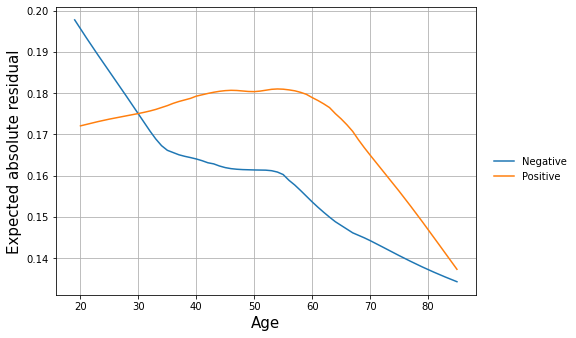

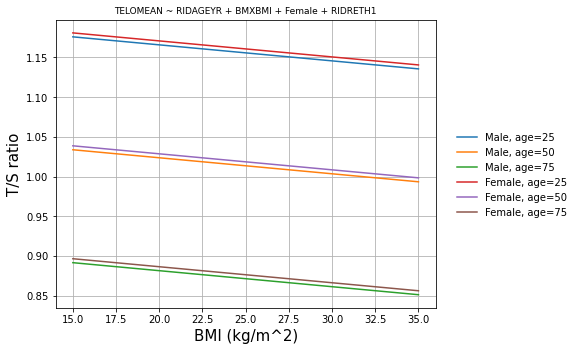

In [8]:
# Main effects only (additive, linear model)
fml0 = "TELOMEAN ~ RIDAGEYR + BMXBMI + Female + RIDRETH1"
model0 = sm.OLS.from_formula(fml0, data=dx)
result0 = model0.fit()
plot_fit_by_age(result0, fml0)
plot_fit_by_bmi(result0, fml0)

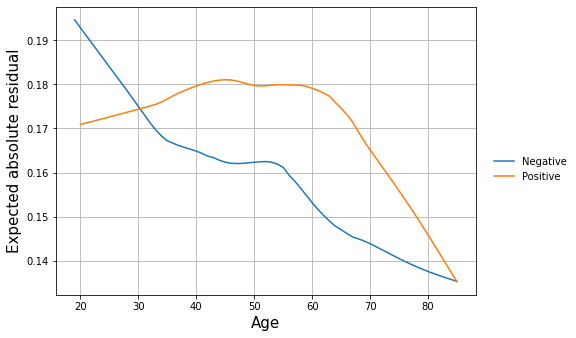

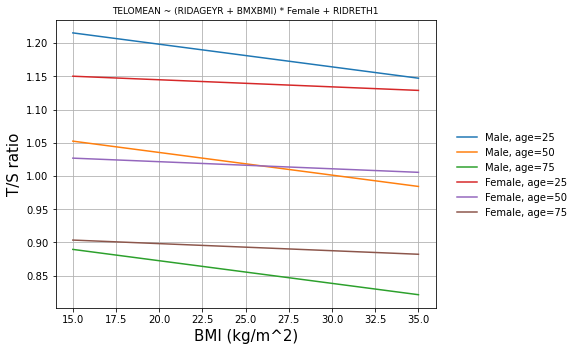

In [9]:
# Interactions but no nonlinearities
fml1 = "TELOMEAN ~ (RIDAGEYR + BMXBMI) * Female + RIDRETH1"
model1 = sm.OLS.from_formula(fml1, data=dx)
result1 = model1.fit()
plot_fit_by_age(result1, fml1)
plot_fit_by_bmi(result1, fml1)

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NotImplementedError: some data points fall outside the outermost knots, and I'm not sure how to handle them. (Patches accepted!)
    TELOMEAN ~ bs(RIDAGEYR, 5) + bs(BMXBMI, 5) + Female + RIDRETH1
               ^^^^^^^^^^^^^^^

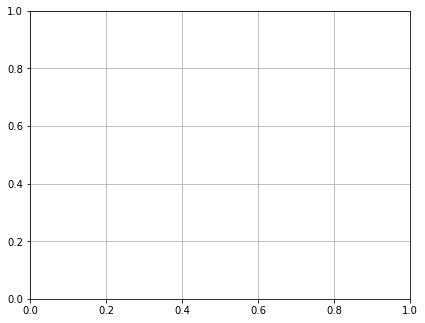

In [10]:
# Nonlinearities but no interactions
fml2 = "TELOMEAN ~ bs(RIDAGEYR, 5) + bs(BMXBMI, 5) + Female + RIDRETH1"
model2 = sm.OLS.from_formula(fml2, data=dx)
result2 = model2.fit()
plot_fit_by_age(result2, fml2)
plot_fit_by_bmi(result2, fml2)

In [ ]:
plot_basis(dx.RIDAGEYR.values, result2.model.exog, result2.model.exog_names, 5)

In [ ]:
# Use AIC to select the degrees of freedom for age and BMI, each of
# which is modeled using spline basis functions.
aic = np.zeros((15, 15)) + np.nan
for age_df in range(3, 15):
    for bmi_df in range(3, 15):
        fml3 = "TELOMEAN ~ bs(RIDAGEYR, age_df) + bs(BMXBMI, bmi_df) + Female + RIDRETH1"
        model3 = sm.OLS.from_formula(fml3, data=dx)
        result3 = model3.fit()
        aic[age_df, bmi_df] = result3.aic

In [ ]:
# Make a heatmap of the AIC values, so we can see where the best fit
# is.
plt.clf()
plt.imshow(aic, interpolation="nearest")
plt.xlabel("BMI df", size=15)
plt.ylabel("Age df", size=15)
plt.colorbar()
plt.xlim(3, 14)
plt.ylim(3, 14)
pdf.savefig()

In [ ]:
# This is the additive spline-based model that is optimal in terms of
# degrees of freedom, as selected by AIC.
fml4 = "TELOMEAN ~ bs(RIDAGEYR, 6) + bs(BMXBMI, 5) + Female + RIDRETH1"
model4 = sm.OLS.from_formula(fml4, data=dx)
result4 = model4.fit()
plot_fit_by_age(result4, fml4)
plot_fit_by_bmi(result4, fml4)

In [ ]:
# This is a polynomial model, provided only for comparison
fml5 = "TELOMEAN ~ RIDAGEYR + I(RIDAGEYR**2) + I(RIDAGEYR**3) + BMXBMI + I(BMXBMI**2) + I(BMXBMI**3) + Female + RIDRETH1"
model5 = sm.OLS.from_formula(fml5, data=dx)
result5 = model5.fit()
plot_fit_by_age(result5, fml5)
plot_fit_by_bmi(result5, fml5)

In [ ]:
# This is another polynomial model
fml6 = "TELOMEAN ~ RIDAGEYR + I(RIDAGEYR**2) + I(RIDAGEYR**3) + I(RIDAGEYR**4) + I(RIDAGEYR**5) + BMXBMI + I(BMXBMI**2) + I(BMXBMI**3) + I(BMXBMI**4) + I(BMXBMI**5) + Female + RIDRETH1"
model6 = sm.OLS.from_formula(fml6, data=dx)
result6 = model6.fit()
plot_fit_by_age(result6, fml6)
plot_fit_by_bmi(result6, fml6)

In [ ]:
# Take model 5 above and allow the curves to vary by sex
fml7 = "TELOMEAN ~ (bs(RIDAGEYR, 6) + bs(BMXBMI, 5)) * Female + RIDRETH1"
model7 = sm.OLS.from_formula(fml7, data=dx)
result7 = model7.fit()
plot_fit_by_age(result7, fml7)
plot_fit_by_bmi(result7, fml7)

In [ ]:
# Now include interactions between age and BMI, along with the other
# interactions, but the role of BMI is conditionally linear
fml8 = "TELOMEAN ~ bs(RIDAGEYR, 5) * BMXBMI * Female + RIDRETH1"
model8 = sm.OLS.from_formula(fml8, data=dx)
result8 = model8.fit()
plot_fit_by_age(result8, fml8)
plot_fit_by_bmi(result8, fml8)

In [ ]:
# This is similar to the model above, except that BMI is now allowed
# to be nonlinear
fml9 = "TELOMEAN ~ bs(RIDAGEYR, 5) * bs(BMXBMI, 4) * Female + RIDRETH1"
model9 = sm.OLS.from_formula(fml9, data=dx)
result9 = model9.fit()
plot_fit_by_age(result9, fml9)
plot_fit_by_bmi(result9, fml9)

In [ ]:
# Model a common nonlinear structure for age and BMI using splines,
# then allow these curves to be translated
fml10 = "TELOMEAN ~ bs(RIDAGEYR, 5) + bs(BMXBMI, 4) + Female * RIDRETH1"
model10 = sm.OLS.from_formula(fml10, data=dx)
result10 = model10.fit()
plot_fit_by_age_race(result10, fml10)

In [ ]:
# Model common nonlinear curves for BMI and age using splines, and
# allow these common curves to vary in a linear manner by age gender
# and ethnicity.
fml11 = "TELOMEAN ~ bs(BMXBMI, 4) + bs(RIDAGEYR, 5) + RIDAGEYR * Female * RIDRETH1"
model11 = sm.OLS.from_formula(fml11, data=dx)
result11 = model11.fit()
plot_fit_by_age_race(result11, fml11)

In [ ]:
pdf.close()